In [121]:
import sys
sys.path.append('../')

import graph.random_graph as random_graph
import util.create_population as create_population
#import core_nn.pure_fit_model as pure_fit_model

import torch
from tqdm import tqdm
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"



In [203]:
class pure_EPI_dense(torch.nn.Module):
    def __init__(self, ISNet, psMatrix, device, train=False, cc=None, sampleAsState=False):
        super(pure_EPI_dense, self).__init__()
        self._n= ISNet.size()[0]
        self._IS= ISNet[None, :]
        self._psMatrix= psMatrix
        self._train= train
        self._device= device
        if train==True:
            self._psMatrix=torch.nn.Parameter(psMatrix)
        self._forceCc=torch.tensor([[0, 1, 0, 0],
                                    [0, 0, 1, 1],
                                    [0, 0, 0, 1],
                                    [0, 0, 0, 0]], device=device) 
        self._cc= cc
        self._Sigmoid= torch.nn.Sigmoid()
        self._sampleAsState= sampleAsState


    def forward(self, state):
        psMatrix= self.get_psMatrix()
        ps10= torch.zeros_like(state, device=self._device)#1*4*1000
        logProbIS= torch.zeros([state.shape[0], self._n, self._n], device=self._device)
        for i in range(state.shape[0]):
            logProbIS[i, :]= torch.log(1-self._IS*state[None, i, 0].T*state[i, 2]*psMatrix[0, 1])#2*1000*1000, 2*1000, 1000*2!
        ps10[:, 1]= 1- torch.exp(torch.sum(logProbIS, dim=2))
        ps10[:, 0]= 1- ps10[:, 1]
        constantM=torch.tensor([[0, 0, 0, 0],
                                [1, 1, 1, 1],
                                [1, 1, 1, 1],
                                [1, 1, 1, 1]], device=self._device) 
        ps2T= (psMatrix*constantM).T
        newState= torch.zeros_like(state, device=self._device)#1*4*1000
        for i in range(state.shape[0]):
            newState[i, :]= state[i, 0, :]*ps10[i, :]+ ps2T.matmul(state[i, :])

        if self._sampleAsState:
            return self.sample_uniform_matrix(newState)

        return newState
    
    def get_population_num(self, state):

        return torch.sum(state, 2)

    #sample nxm pobability matrix, of 0 dimension, which contains n choise for a random variable
    def sample_uniform_matrix(self, P):  
        state= torch.zeros_like(P, device=self._device)
        U= torch.rand(self._n).to(self._device)
        for i in range(P.size()[1]):
            U= U- P[:, i]
            state[:, i]= U<0
            U= U+state[:, i]
        return state
    
    def get_population_dir(self, state):
        return { #a columnar DB somewhat reminds the Pandas DataFrame 
                "S": state[0],
                "E": state[1],
                "I": state[2],
                "R": state[3],
                }
    
    def get_original_transition_matrix(self):
        
        return self._psMatrix
    
    def expand_psMatrix(self, psMatrix):
        stabelProb= 1- torch.sum(psMatrix, 1)
        psSize= psMatrix.shape[0]
        eyeM= torch.eye(psSize, device=self._device)
        return eyeM*stabelProb+psMatrix

    
    def get_psMatrix(self):
        if self._train== True:
            psMatrix= self._Sigmoid(self._psMatrix)
            psMatrix= psMatrix*self._forceCc
            if self._cc is not None:
                psMatrix= psMatrix*self._cc
            return self.expand_psMatrix(psMatrix)
        else:
            return self.expand_psMatrix(self._psMatrix)

In [153]:
def sim(timeHorizon, model: pure_EPI_dense, state):
  populationNumber= []
  states = [state]
  for _ in range(timeHorizon):
    state= model(state)
    populationNumber.append(model.get_population_num(state))
    states.append(torch.clone(state))
  populationNumber = torch.stack(populationNumber)
  states = torch.stack(states)
  return populationNumber, states

In [204]:
n= 1000
avgDegree= 4
timeHorizon= 50
print("haha")
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
print("haha")
contact = contact.requires_grad_(True)
ps=     torch.tensor([[0, 0.3, 0, 0],
                      [0, 0, 0.6, 0],
                      [0, 0, 0, 0.1],
                      [0, 0, 0, 0]], device=device)
state= create_population.population(n, device)
state= state[None, :]
model=pure_EPI_dense(contact, ps, device=device, sampleAsState= False)
with torch.no_grad():
    realData, _= sim(timeHorizon, model=model, state=state)
    realData= realData.squeeze()

haha
haha


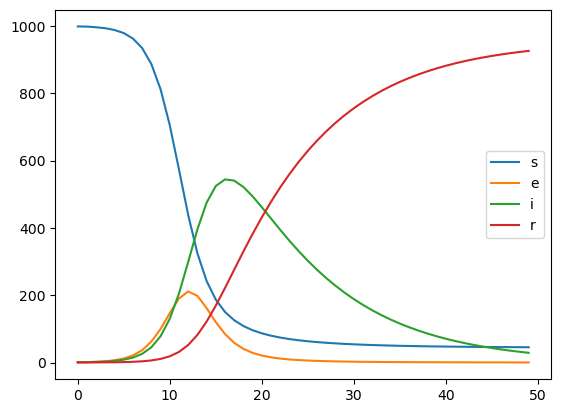

In [205]:
plotRealNumber= realData.cpu().detach()
plt.plot(plotRealNumber, label=["s", "e", "i", "r"])
plt.legend()

In [230]:
windowSize= 3
batchSize= 40
realData.requires_grad_(True)
psFit= torch.zeros([4, 4], device=device)
cc= torch.tensor([[0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0]], device=device)
modelFit= pure_EPI_dense(contact, psFit, device=device, cc=cc, train=True, sampleAsState=False)
lossFn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(modelFit.parameters(), lr=1e-2)
#generate dataset
def generate_dateset(model: pure_EPI_dense, ys, timeHorizon=100, windowSize= 5):
    with torch.no_grad():
        stateZero = create_population.population(n, device)
        stateZero= stateZero[None, :]
        _, states= sim(timeHorizon-windowSize-1, model, stateZero)#generate data more times?
        states= states.squeeze()
        infectiveNum=[]
        for i in range(timeHorizon-windowSize):
            infectiveNum.append(ys[i: i+windowSize])
        infectiveNum= torch.stack(infectiveNum)
        dataset = torch.utils.data.TensorDataset(states, infectiveNum)
        return dataset, states

In [241]:
losses= []

for i in tqdm(range(100)):
    dataset, states= generate_dateset(modelFit, realData[ :, 2], timeHorizon, windowSize= windowSize)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle = True)
    #with torch.autograd.set_detect_anomaly(True):
    for batch in dataloader:
        optimizer.zero_grad()
        fitY= []
        x, y = batch
        x=[x]
        for j in range(windowSize):
            out= modelFit(x[-1])
            fitY.append(model.get_population_num(out))
            x.append(out)
        y= y.T
        fitY= torch.stack(fitY)
        loss= lossFn(fitY[:, :, 2], y)/n/windowSize
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        break
        

100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


torch.Size([47, 4, 1000])
tensor([[0.6998, 0.3002, 0.0000, 0.0000],
        [0.0000, 0.4996, 0.5004, 0.0000],
        [0.0000, 0.0000, 0.9021, 0.0979],
        [0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0',
       grad_fn=<AddBackward0>)
torch.Size([47, 4])


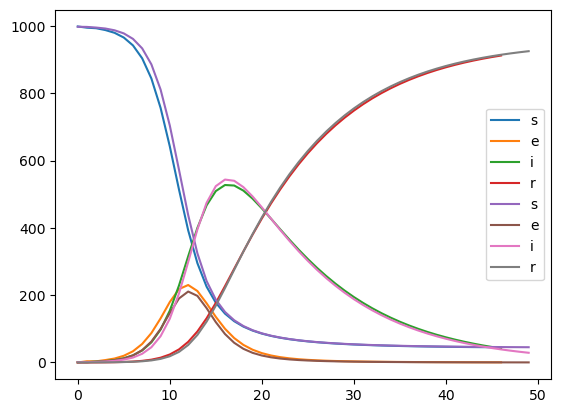

In [242]:
plotSatte= states.cpu().detach()
print(plotSatte.shape)
print(modelFit.get_psMatrix())
plotSatte= plotSatte.sum(dim=2)
print(plotSatte.shape)
plt.plot(plotSatte, label=["s", "e", "i", "r"])
plt.plot(plotRealNumber, label=["s", "e", "i", "r"])
plt.legend()

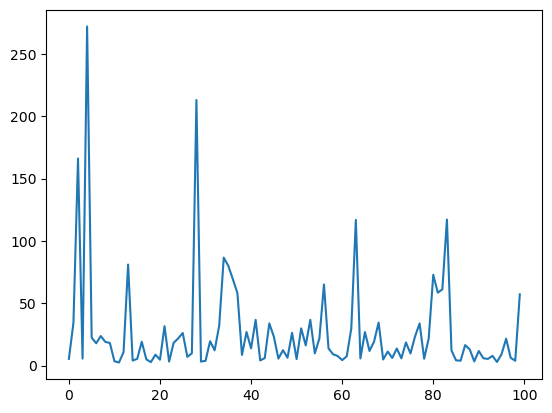

In [243]:
plt.plot(losses)

In [60]:
def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')
print_model_parameters(modelFit)

name           : _psMatrix
parameter      : Parameter containing:
tensor([[ 0.0000, -0.0056,  0.0000,  0.0000],
        [-0.0048,  0.0000, -0.0077,  0.0052],
        [-0.0090, -0.0090,  0.0000, -0.0090],
        [-0.0054, -0.0050, -0.0080,  0.0000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[ 0.0000e+00,  1.7447e+00,  0.0000e+00,  0.0000e+00],
        [ 8.8377e-02,  0.0000e+00,  1.9897e+00, -3.5965e-03],
        [ 5.1910e+00,  5.4729e+00,  0.0000e+00,  5.4853e+00],
        [ 2.3399e-02,  9.6211e-04,  5.4539e-01,  0.0000e+00]], device='cuda:0')
---------------------------------
